In [42]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC
using Statistics, Random, Distributions

In [43]:
# アジアン・バリアオプションのモンテカルロシミュレーション（インデックス渡し版）
function asian_barrier_option_tci(j, T, K, B, S0s, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)
    discounted_payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]
    for i in 1:N_PATHS
        s_curr = S0
        running_avg = 0.0
        for n in 1:N_STEPS
            s_curr += tmp1 * s_curr + sigma * s_curr * tmp3 * d_normals[i + (n-1)*N_PATHS]
            running_avg += (s_curr - running_avg) / n
            if running_avg <= B
                break
            end
        end
        discounted_payoffs[i] = tmp2 * max(running_avg - K, 0)
    end
    mean_payoff = mean(discounted_payoffs)
    std_payoff = std(discounted_payoffs)
    error = std_payoff / sqrt(N_PATHS)
    return mean_payoff
end

# アジアン・バリアオプションのモンテカルロシミュレーション（インデックス渡し版）
function asian_barrier_option_error(j, T, K, B, S0s, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)
    discounted_payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]
    for i in 1:N_PATHS
        s_curr = S0
        running_avg = 0.0
        for n in 1:N_STEPS
            s_curr += tmp1 * s_curr + sigma * s_curr * tmp3 * d_normals[i + (n-1)*N_PATHS]
            running_avg += (s_curr - running_avg) / n
            if running_avg <= B
                break
            end
        end
        discounted_payoffs[i] = tmp2 * max(running_avg - K, 0)
    end
    mean_payoff = mean(discounted_payoffs)
    std_payoff = std(discounted_payoffs)
    error = std_payoff / sqrt(N_PATHS)
    return mean_payoff, error
end

# TCIワンショット補間関数
function tci_oneshot(func, d, localdims, firstpivot, tol)
    BLAS.set_num_threads(4)
    for _ in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot)
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end
    qtt, ranks, errors = TCI.crossinterpolate2(Float64, func, localdims, [firstpivot],
                                                  tolerance=tol, maxiter=6, verbosity=1,
                                                  loginterval=1, pivotsearch=:rook)
    return qtt, errors
end

tci_oneshot (generic function with 1 method)

In [44]:
#―――――――――――――――――――――――――――――――――――――――
# 1) パスごとの割引後ペイオフを返す関数
#―――――――――――――――――――――――――――――――――――――――
function asian_barrier_payoffs(
    j, T, K, B,
    S0s, sigmas, mu, r,
    d_normals, N_STEPS, N_PATHS
) :: Vector{Float64}
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)

    payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]

    for i in 1:N_PATHS
        s = S0
        avg = 0.0
        for n in 1:N_STEPS
            s += tmp1 * s + sigma * s * tmp3 * d_normals[i + (n-1)*N_PATHS]
            avg += (s - avg) / n
            if avg <= B
                # バリア割れならペイオフ0でループ脱出
                avg = 0.0
                break
            end
        end
        payoffs[i] = tmp2 * max(avg - K, 0)
    end
    return payoffs
end

"""
    vega_asian_barrier(
        j, T, K, B,
        S0s, sigmas, mu, r,
        d_normals, N_STEPS, N_PATHS;
        h_sigma = 1e-4
    ) -> (Float64, Float64)

アジアンバリアオプションの Vega を中心差分で近似し、(推定値, 推定誤差) を返す関数。

- j: (iS0, iSigma)
- h_sigma: ボラティリティに対する小さな変化量
"""
function vega_asian_barrier(
    j, T, K, B,
    S0s, sigmas, mu, r,
    d_normals, N_STEPS, N_PATHS;
    h = 1e-4
) :: Tuple{Float64, Float64}

    # 1) ボラティリティを ±h_sigma ずらしたベクトルを作成
    sigmas_up   = copy(sigmas)
    sigmas_down = copy(sigmas)

    sigmas_up[j[2]]   = sigmas[j[2]] + h
    sigmas_down[j[2]] = sigmas[j[2]] - h

    # 2) 上側 (sigma + h_sigma) のペイオフ
    pay_plus = asian_barrier_payoffs(
        j, T, K, B,
        S0s, sigmas_up, mu, r,
        d_normals, N_STEPS, N_PATHS
    )

    # 3) 下側 (sigma - h_sigma) のペイオフ
    pay_minus = asian_barrier_payoffs(
        j, T, K, B,
        S0s, sigmas_down, mu, r,
        d_normals, N_STEPS, N_PATHS
    )

    # 4) パスごとの価格差分 (centered difference)
    #    Vega = [C(σ + h_sigma) - C(σ - h_sigma)] / (2*h_sigma)
    vega_path = (pay_plus .- pay_minus) ./ (2*h)

    # 5) 平均と標準誤差
    vega_mean = mean(vega_path)
    vega_err  = std(vega_path) / sqrt(N_PATHS)

    return vega_mean, vega_err
end

vega_asian_barrier

In [45]:
##########################################################
# パラメータの設定とグリッド生成
##########################################################
d = 2
N_STEPS = 365
N_PATHS = 1000       # サンプル数（テスト用なので少なめ）
T = 1.0
K = 110.0
B = 100.0
mu = 0.1
r = 0.05

Random.seed!(1234)
d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 100
n = num_nodes
S0_values = TCIMC.calc_cheby_abscissas(90.0, 120.0, num_nodes)
implied_vol_values = TCIMC.calc_cheby_abscissas(0.15, 0.25, num_nodes)

# インデックスを渡す設計のため、例として j = [30, 30] を利用
j = [90, 30]
h_ = 1e-1
vega_mean, vega_err = vega_asian_barrier(
    j, T, K, B,
    S0_values, implied_vol_values, mu, r,
    d_normals, N_STEPS, N_PATHS;
    h = h_
)

println("vega ≈ $vega_mean ± $vega_err")


vega ≈ 10.943222802667934 ± 2.0106227655272915


In [46]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
abo(j) = asian_barrier_option_tci(j, T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
localdims_v = fill(num_nodes, d)
firstpivot_v = rand(1:num_nodes, d)
phi = TCI.CachedFunction{Float64}(abo, localdims_v)
tol = 1e-2
#tol = 0.00101
#tol = tol_mc

tci_time = @elapsed begin
    tt_tci, errors_asianbarrier = tci_oneshot(phi, d, localdims_v, firstpivot_v, tol)
end

##########################################################

iteration = 1, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0
iteration = 2, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0
iteration = 3, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0


4.247229375

In [47]:
# Grid上での評価結果の比較（TCI vs. Monte Carlo）
##########################################################
# TCIによる評価結果の行列（TT評価はTCIMC._evaluateを利用）
deltamatrix_tci = zeros(n, n)
for i in 1:n, j in 1:n
    deltamatrix_tci[i, j] = TCIMC._evaluate(tt_tci.sitetensors, [i, j])
end

# Monte Carloによる評価結果の行列
price_matrix_mc = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_mc[i, j] = asian_barrier_option_tci([i, j], T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
end

tol_svd = 1e-3
US, Vt = TCI._factorize(price_matrix_mc, :SVD; tolerance = tol_svd, maxbonddim=1000)
U_core = reshape(US, 1, size(US)[1], size(US)[2])
Vt_core = reshape(Vt, size(Vt)[1], size(Vt)[2], 1)

tt_svd_ = [U_core, Vt_core]
@show size(U_core)
@show size(Vt_core)

tt_svd = TCI.TensorTrain(tt_svd_)

price_matrix_svd = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_svd[i,j] = TCIMC._evaluate(tt_svd.sitetensors, [i, j])
end

size(U_core) = (1, 100, 3)
size(Vt_core) = (3, 100, 1)


In [48]:
num_samples = 100
errors = zeros(Float64, num_samples)
vegas = zeros(Float64, num_samples)

for i in 1:num_samples
    # 1～num_nodesの範囲からランダムにインデックスを選ぶ
    j1 = rand(1:num_nodes)
    j2 = rand(1:num_nodes)
    j = [j1, j2]

    vega, vega_error  = vega_asian_barrier(
        j, T, K, B,
        S0_values, 
        implied_vol_values,
        mu, 
        r,
        d_normals,
        N_STEPS, N_PATHS
    )

    errors[i] = vega_error
    vegas[i] = vega
end

In [49]:
#=
tol = 0.03038718241470662
JLD2.@load "tt_tci_asian_barrier_$tol.jld2" tt_tci
tol_svd = 0.001
JLD2.@load "tt_svd_asian_barrier_$tol_svd.jld2" tt_svd

tt_tci = tt_tci
tt_svd = tt_svd
=#

In [50]:
M_dct = TCIMC.dct_matrix(n)
C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, 2))
C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_svd), fill(M_dct, 2))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

## S0を固定した上で、sigma方向に計算ver

In [55]:
# -------------------------------
# どこかで定義済みの辞書 (TCI, SVD, MC) 
# 存在しない場合は空の Dict を用意
# -------------------------------
vega_dict_tci = Dict{Tuple{Int,Int}, Float64}()
vega_dict_svd = Dict{Tuple{Int,Int}, Float64}()
vega_dict_mc  = Dict{Tuple{Int,Int}, Float64}()

# 結果格納用ベクトル
tci_vals = Float64[]
svd_vals = Float64[]
mc_vals  = Float64[]
xvals    = Float64[]  # x 軸となる implied_vol_values_equiv[j]

# -------------------------------
# 行をひとつ選択
# -------------------------------
row_index = 90  # 例: 90行目
selected_S0 = S0_values_equiv[row_index]
println("選択した行 index: ", row_index, ",  S0 = ", selected_S0)

# -------------------------------
# ループ開始
# -------------------------------
for j in 1:num_nodes
    vol_val = implied_vol_values_equiv[j]
    push!(xvals, vol_val)  # x 軸に追加

    # ========== TCI ==========
    weights = [
        TCIMC.chebyshev_basis(90.0, 120.0, selected_S0, n),
        TCIMC.chebyshev_basis_derivative(0.15, 0.25, vol_val, n)
    ]
    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    vega_tci = TCIMC.update_center(
        C_coeff_tensor_tci, left_cache, right_cache, weights[c], c
    )
    vega_dict_tci[(row_index, j)] = vega_tci
    push!(tci_vals, vega_tci)

    # ========== SVD ==========
    weights = [
        TCIMC.chebyshev_basis(90.0, 120.0, selected_S0, n),
        TCIMC.chebyshev_basis_derivative(0.15, 0.25, vol_val, n)
    ]
    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
    vega_svd = TCIMC.update_center(
        C_coeff_tensor_svd, left_cache, right_cache, weights[c], c
    )
    vega_dict_svd[(row_index, j)] = vega_svd
    push!(svd_vals, vega_svd)

    # ========== MC ==========
    # vega_asian_barrier は (row_index, j) の位置で計算すると仮定
    vega_mean, vega_err = vega_asian_barrier(
        (row_index, j), T, K, B,
        S0_values_equiv, implied_vol_values_equiv,
        mu, r, d_normals, N_STEPS, N_PATHS;
        h = h_vega
    )
    vega_dict_mc[(row_index, j)] = vega_mean
    push!(mc_vals, vega_mean)
end

# これで tci_vals, svd_vals, mc_vals, xvals に対応するデータが揃います


選択した行 index: 90,  S0 = 116.96969696969697


In [56]:
@JLD2.save "svd_vals_1d_vol_asian_barrier.jld2" svd_vals
@JLD2.save "tci_vals_1d_vol_asian_barrier.jld2" tci_vals
@JLD2.save "mc_vals_1d_vol_asian_barrier.jld2" mc_vals
@JLD2.save "xvals_1d_vol_asian_barrier.jld2" xvals


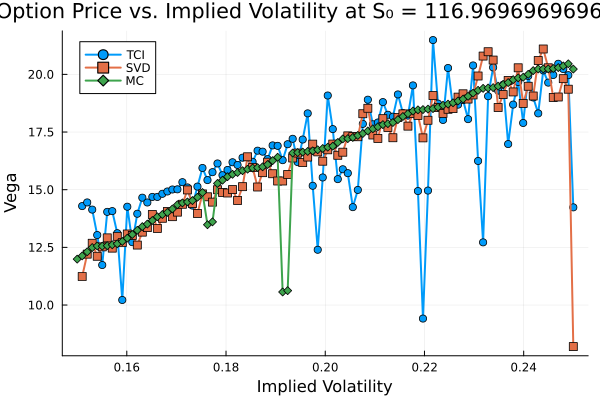

In [57]:
using Plots

# -------------------------------
# プロット設定
# -------------------------------
p = plot(
    xvals, tci_vals,
    label = "TCI",
    lw = 2,
    marker = :circle,
    xlabel = "Implied Volatility",
    ylabel = "Vega",
    title = "Option Price vs. Implied Volatility at S₀ = $(selected_S0)",
    legend = :topleft,
    grid = true
)

plot!(xvals, svd_vals, label = "SVD", lw = 2, marker = :square)
plot!(xvals, mc_vals,  label = "MC",  lw = 2, marker = :diamond)

# -------------------------------
# プロットを表示
# -------------------------------
display(p)
